---
# 1) Resumo:

Neste notebook iremos fazer a exploração inicial da base de dados do [Sírio-Libanês](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19). 

Além da exploração também iremos fazer a limpeza e preparação da base de dados. Inicialmente o aquivo tem **1925** linhas e **231** colunas. Após o tratamento o arquivo final tem **351** linhas e **181** colunas. O tratamento foi basicamente:

1. Retirada de pacientes que já foram para UTI na primeira janela de atendimento (0-2h).
2. Preenchimento de dados **NaN** nas colunas das variaveis continuas.
3. Descarte de qualquer linha que ainda tenha valores **NaN** após a **etapa 2**.
4. Apenas informoções dos pacientes da primeira janela. Assim temos uma linha por paciente.
5. Transformação da colunas AGE_PERCENTIL para numérica.
6. Descarte das colunas WINDOW e PATIENT_VISIT_IDENTIFIER.
7. Descarte das colunas com variancia menor que 0.01.

O arquivo final tratado ainda passará por mais outros notebooks para uma seleção mais fina das variaveis explicativas.


---
# 2) Pre-analise

## 2.1) Importando libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold

pd.set_option('display.max_rows', 50)

### 2.2 ) Minhas funções

In [2]:
import sys
sys.path.insert(1, "../../")
import src.limpeza_dados as cl
from src.plota_graficos import plot_barras, plot_barras_grupos
from src.info import dimensao_dados, variaveis_explicativas,escreve_somente_as_colunas

---
# 3) Explorando os dados

---
# 3.1) Importando os dados

In [3]:
path = "https://github.com/HenriqueCCdA/BC_DS_Projeto_Final/blob/main/Dados/Brutos/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true"

dados = pd.read_excel(path)
dados.head(n=5)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [4]:
dimensao_dados(dados)

Numero de linhas : 1925 
Numero de colunas: 231 


In [5]:
print(dados.dtypes)

PATIENT_VISIT_IDENTIFIER        int64
AGE_ABOVE65                     int64
AGE_PERCENTIL                  object
GENDER                          int64
DISEASE GROUPING 1            float64
                               ...   
RESPIRATORY_RATE_DIFF_REL     float64
TEMPERATURE_DIFF_REL          float64
OXYGEN_SATURATION_DIFF_REL    float64
WINDOW                         object
ICU                             int64
Length: 231, dtype: object


In [6]:
dados.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,...,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,...,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333,0.000000
75%,288.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.647059,-0.595238,-0.878788,-0.645482,-0.522176,-0.662529,-0.634409,-0.594677,-0.880155,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
dados.iloc[:21,[0,-2,-1]]

,PATIENT_VISIT_IDENTIFIER,WINDOW,ICU
0,0,0-2,0
1,0,2-4,0
2,0,4-6,0
3,0,6-12,0
4,0,ABOVE_12,1
5,1,0-2,1
6,1,2-4,1
7,1,4-6,1
8,1,6-12,1
9,1,ABOVE_12,1


In [8]:
n_pacientes_inicial = len(dados['PATIENT_VISIT_IDENTIFIER'].unique())
print('Numero de pacientes', n_pacientes_inicial)

Numero de pacientes 385


In [9]:
dados['AGE_PERCENTIL'].unique()

array(['60th', '90th', '10th', '40th', '70th', '20th', '50th', '80th',
       '30th', 'Above 90th'], dtype=object)

In [10]:
names = ['HTN', 'IMMUNOCOMPROMISED', 'OTHER', 'GENDER', 'AGE_ABOVE65',
         'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
         'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6',
         'WINDOW', 'ICU', 'AGE_PERCENTIL']
for name in names:
  print(f'{name:20} ->', dados[name].unique())

HTN                  -> [ 0.  1. nan]
IMMUNOCOMPROMISED    -> [ 0.  1. nan]
OTHER                -> [ 1.  0. nan]
GENDER               -> [0 1]
AGE_ABOVE65          -> [1 0]
DISEASE GROUPING 1   -> [ 0.  1. nan]
DISEASE GROUPING 2   -> [ 0.  1. nan]
DISEASE GROUPING 3   -> [ 0.  1. nan]
DISEASE GROUPING 4   -> [ 0.  1. nan]
DISEASE GROUPING 5   -> [ 1.  0. nan]
DISEASE GROUPING 6   -> [ 1.  0. nan]
WINDOW               -> ['0-2' '2-4' '4-6' '6-12' 'ABOVE_12']
ICU                  -> [0 1]
AGE_PERCENTIL        -> ['60th' '90th' '10th' '40th' '70th' '20th' '50th' '80th' '30th'
 'Above 90th']


In [11]:
for name in dados.columns:
  if 'ALBUMIN' in name:
    print(name)

ALBUMIN_MEDIAN
ALBUMIN_MEAN
ALBUMIN_MIN
ALBUMIN_MAX
ALBUMIN_DIFF


In [12]:
for name in dados.columns:
  if 'OXYGEN_SATURATION' in name:
    print(name)

OXYGEN_SATURATION_MEAN
OXYGEN_SATURATION_MEDIAN
OXYGEN_SATURATION_MIN
OXYGEN_SATURATION_MAX
OXYGEN_SATURATION_DIFF
OXYGEN_SATURATION_DIFF_REL


> Verificando as colunas que só tem dois valores únicos. No caso NaN e -1. Estas colunas são candidatas a exclusão pois como todas tem as linhas temo o mesmo valores não agregaria nenhuma informação aos modelos de **ML**.

In [13]:
cl.colunas_com_apenas_n_valores_unicos(dados, 2)

Colunas com apenas 2 valores unicos:
ALBUMIN_DIFF         -> [nan -1.]
BE_ARTERIAL_DIFF     -> [nan -1.]
BE_VENOUS_DIFF       -> [nan -1.]
BIC_ARTERIAL_DIFF    -> [nan -1.]
BIC_VENOUS_DIFF      -> [nan -1.]
BILLIRUBIN_DIFF      -> [nan -1.]
BLAST_DIFF           -> [nan -1.]
CALCIUM_DIFF         -> [nan -1.]
CREATININ_DIFF       -> [nan -1.]
FFA_DIFF             -> [nan -1.]
GGT_DIFF             -> [nan -1.]
GLUCOSE_DIFF         -> [nan -1.]
HEMATOCRITE_DIFF     -> [nan -1.]
HEMOGLOBIN_DIFF      -> [nan -1.]
INR_DIFF             -> [nan -1.]
LACTATE_DIFF         -> [nan -1.]
LEUKOCYTES_DIFF      -> [nan -1.]
LINFOCITOS_DIFF      -> [nan -1.]
NEUTROPHILES_DIFF    -> [nan -1.]
P02_ARTERIAL_DIFF    -> [nan -1.]
P02_VENOUS_DIFF      -> [nan -1.]
PC02_ARTERIAL_DIFF   -> [nan -1.]
PC02_VENOUS_DIFF     -> [nan -1.]
PCR_DIFF             -> [nan -1.]
PH_ARTERIAL_DIFF     -> [nan -1.]
PH_VENOUS_DIFF       -> [nan -1.]
PLATELETS_DIFF       -> [nan -1.]
POTASSIUM_DIFF       -> [nan -1.]
SAT02_ARTER

---
## 3.2) Resumo:

>Geral:
* Número de linhas  : 1925 
* Número de colunas : 231
* Colunas 0, 1, 3 e 230 tipo int64
* Colunas 2 e 229 tipo string
* Colunas 4 a 228 tipo float64
* Número de pacientes: 385 (cada paciente tem mutiplicas entradas por janelas de tempo)

>Colunas categoricas 0 ou 1:
* HTN                  -> [ 0.  1. nan]
* IMMUNOCOMPROMISED    -> [ 0.  1. nan]
* OTHER                -> [ 1.  0. nan]
* GENDER               -> [0 1] [ mascilino feminio]
* AGE_ABOVE65          -> [1 0]
* DISEASE GROUPING 1   -> [ 0.  1. nan]
* DISEASE GROUPING 2   -> [ 0.  1. nan]
* DISEASE GROUPING 3   -> [ 0.  1. nan]
* DISEASE GROUPING 4   -> [ 0.  1. nan]
* DISEASE GROUPING 5   -> [ 1.  0. nan]
* DISEASE GROUPING 6   -> [ 1.  0. nan]

>Colunas categoricas Multi-Label:
* WINDOW               -> ['0-2' '2-4' '4-6' '6-12' 'ABOVE_12']
* AGE_PERCENTIL        -> ['60th' '90th' '10th' '40th' '70th' '20th' '50th' '80th' '30th'
 'Above 90th']

>Possivel divisão das idades:
* 10th - 0  a 10 anos
* 20th - 11 a 20 anos
* 30th - 21 a 30 anos
* 40th - 31 a 20 anos
* 50th - 41 a 50 anos
* 60th - 51 a 60 anos
* 70th - 71 a 80 anos
* 80th - 81 a 90 anos
* 90th - 91 a 100 anos
* Above 90th - 101 ... anos

>OBS:
* Hypertension (HTN) 
* Imunodepressivos (IMMUNOCOMPROMISED)  
* UTI (intensive care unit)

> Nas colunas 13 até 228 as variaveis são continuas
>
> Por exemplo:

* OXYGEN_SATURATION_MEDIAN - mediana 
* OXYGEN_SATURATION_MEAN   - media
* OXYGEN_SATURATION_MIN    - minimo
* OXYGEN_SATURATION_MAX    - maximo
* OXYGEN_SATURATION_DIFF   - max - min         
* OXYGEN_SATURATION_DIFF_REL  - diff/median - (max - min)/median  (**nem todos tem**)

> porém nem todas temo o campo **DIFF_REL**

>As colunas parecem ter apenas o valor -1

* ALBUMIN_DIFF        
* DE_ARTERIAL_DIFF    
* BE_VENOUS_DIFF      
* BIC_ARTERIAL_DIFF   
* BIC_VENOUS_DIFF     
* BILLIRUBIN_DIFF     
* BLAST_DIFF          
* CALCIUM_DIFF        
* CREATININ_DIFF      
* FFA_DIFF            
* GGT_DIFF            
* GLUCOSE_DIFF        
* HEMATOCRITE_DIFF    
* HEMOGLOBIN_DIFF     
* INR_DIFF            
* LACTATE_DIFF        
* LEUKOCYTES_DIFF     
* LINFOCITOS_DIFF     
* NEUTROPHILES_DIFF   
* P02_ARTERIAL_DIFF   
* P02_VENOUS_DIFF     
* PC02_ARTERIAL_DIFF  
* PC02_VENOUS_DIFF    
* PCR_DIFF            
* PH_ARTERIAL_DIFF    
* PH_VENOUS_DIFF      
* PLATELETS_DIFF      
* POTASSIUM_DIFF      
* SAT02_ARTERIAL_DIFF 
* SAT02_VENOUS_DIFF   
* SODIUM_DIFF         
* TGO_DIFF            
* TGP_DIFF            
* TTPA_DIFF           
* UREA_DIFF           
* DIMER_DIFF


---
# 4) Tratamento dos dados

In [14]:
dados.iloc[:21,[0,-2,-1]]

,PATIENT_VISIT_IDENTIFIER,WINDOW,ICU
0,0,0-2,0
1,0,2-4,0
2,0,4-6,0
3,0,6-12,0
4,0,ABOVE_12,1
5,1,0-2,1
6,1,2-4,1
7,1,4-6,1
8,1,6-12,1
9,1,ABOVE_12,1


In [15]:
ICU_window_0_2, _, _, _ = cl.pacientes_por_janela_ICU(dados)

Numero de ICU igual a 1
Janela 0-2 : 32
Janela 2-4 : 59
Janela 4-6 : 99
Janela 6-12: 130


> Pacientes que foram para uti por janela. Aqui temos que 32 pacientes foram para a UTI na janela 0-2.

In [16]:
ICU_window_0_2 # pacientes que precisam ser retirados

5         1
85       17
135      27
205      41
235      47
240      48
270      54
310      62
425      85
450      90
520     104
530     106
545     109
585     117
720     144
880     176
1010    202
1030    206
1130    226
1165    233
1195    239
1305    261
1350    270
1410    282
1430    286
1530    306
1575    315
1645    329
1795    359
1810    362
1830    366
1895    379
Name: PATIENT_VISIT_IDENTIFIER, dtype: int64

## 4.2) Manipulando os dados

* Retirando os pacientes que foram para a **UTI** na janela 0-2
* Preenchimento dos valores NaN nas variaveis continuas
* retirandos os valores NaN que restaram

In [17]:
dados_tratados = dados.copy()
# Retirando os pacientes que foram para a UTI na janela 0-2
dados_tratados = cl.retira_paciente_primeira_janela(dados_tratados)
# Preenchimento dos valores NaN nas variaveis continuas
dados_tratados = cl.preenchendo_var_continuas(dados_tratados)
# retira todas alinhas que ainda tem valores NaN
dados_tratados = dados_tratados.dropna()

In [18]:
dados_tratados.head(n=15)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
5,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,0
6,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,2-4,0
7,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,4-6,0
8,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.797980,-0.658863,-0.563758,-0.721834,-0.926882,-1.000000,-0.801293,6-12,0
9,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.500000,-0.898990,-0.612422,-0.343258,-0.576744,-0.695341,-0.505464,-0.900129,ABOVE_12,1


## 4.2.1) Checando se os pacientes foram corretamente retirados

In [19]:
# verificando se tem algum paciente ICU no intervalo 0-2
_, _, _, _, = cl.pacientes_por_janela_ICU(dados_tratados)

Numero de ICU igual a 1
Janela 0-2 : 0
Janela 2-4 : 27
Janela 4-6 : 67
Janela 6-12: 98


>* Janela 0-2 : 32 - 32  = 0
>* Janela 2-4 : 59 - 32  = 27
>* Janela 4-6 : 99 - 32  = 67
>* Janela 6-12: 130 - 32 = 98
>
> Pode-se observar que os 32 pacientes foram retidados corretamente

## 4.2.2)  Checando se anda existem NaN

In [20]:
for col in dados_tratados:
  if dados_tratados[col].isna().sum():
    print("Valores NaN na coluna", col, dados_tratados[col].isna().sum())

> Logo não temos nenhum dado NaN remanecente

In [21]:
nl, nc = dados_tratados.shape
print(f"Numero de linhas : {nl} ")
print(f"Numero de colunas: {nc} ")

Numero de linhas : 1645 
Numero de colunas: 231 


## 4.3) Uma linha por paciente

> Pegando as informações de apenas da janela 0-2

In [22]:
dados_tratados_por_paciente = dados_tratados\
                              .groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)\
                              .apply(cl.uma_linha_por_paciente)

In [23]:
dados_tratados_por_paciente.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
4,5,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0


In [24]:
n_pacientes, _ = dados_tratados_por_paciente.shape
print(f"Numero de pacientes inicial : {n_pacientes_inicial}")
print(f"Numero de pacientes validos : {n_pacientes} ")

Numero de pacientes inicial : 385
Numero de pacientes validos : 351 


> Verificando novamente as colunas que só tem um valor único. 

In [25]:
cl.colunas_com_apenas_n_valores_unicos(dados_tratados_por_paciente, 1)

Colunas com apenas 1 valores unicos:
ALBUMIN_DIFF         -> [-1.]
BE_ARTERIAL_DIFF     -> [-1.]
BE_VENOUS_DIFF       -> [-1.]
BIC_ARTERIAL_DIFF    -> [-1.]
BIC_VENOUS_DIFF      -> [-1.]
BILLIRUBIN_DIFF      -> [-1.]
BLAST_DIFF           -> [-1.]
CALCIUM_DIFF         -> [-1.]
CREATININ_DIFF       -> [-1.]
FFA_DIFF             -> [-1.]
GGT_DIFF             -> [-1.]
GLUCOSE_DIFF         -> [-1.]
HEMATOCRITE_DIFF     -> [-1.]
HEMOGLOBIN_DIFF      -> [-1.]
INR_DIFF             -> [-1.]
LACTATE_DIFF         -> [-1.]
LEUKOCYTES_DIFF      -> [-1.]
LINFOCITOS_DIFF      -> [-1.]
NEUTROPHILES_DIFF    -> [-1.]
P02_ARTERIAL_DIFF    -> [-1.]
P02_VENOUS_DIFF      -> [-1.]
PC02_ARTERIAL_DIFF   -> [-1.]
PC02_VENOUS_DIFF     -> [-1.]
PCR_DIFF             -> [-1.]
PH_ARTERIAL_DIFF     -> [-1.]
PH_VENOUS_DIFF       -> [-1.]
PLATELETS_DIFF       -> [-1.]
POTASSIUM_DIFF       -> [-1.]
SAT02_ARTERIAL_DIFF  -> [-1.]
SAT02_VENOUS_DIFF    -> [-1.]
SODIUM_DIFF          -> [-1.]
TGO_DIFF             -> [-1.]
TGP

In [26]:
#dados_tratados_por_paciente.iloc[0:5,:-1].to_csv('novos_pacientes.csv', index_label=False)

## 4.4) Modificando a coluna AGE_PERCENTIL

AGE_PERCENTIL| valor proposto |
:-----------:|:--------------:|
   10th      |    0  |
   20th      |    1  |          
   30th      |    2  |     
   40th      |    3  |     
   50th      |    4  | 
   60th      |    5  |       
   70th      |    6  | 
   80th      |    7  |
   90th      |    8  |
   Above 90th|    9  |          


In [27]:
#valores = np.array([0,1,2,3,4,5,6,7,8,9])

#media = np.mean(valores)
#z = valores - media
#max   = np.abs(np.max(z))
#z = z / max
#z = valores
#z 

#mapi = { '10th'      : z[0], '20th'      : z[1], '30th'      : z[2],
#         '40th'      : z[3], '50th'      : z[4], '60th'      : z[5],
#         '70th'      : z[6], '80th'      : z[7], '90th'      : z[8],
#         'Above 90th': z[9],
#} 

In [28]:
def transforma_age_percentil(dados):
    valores = np.array([0,1,2,3,4,5,6,7,8,9])    
    media = np.mean(valores)
    z = valores - media
    max   = np.abs(np.max(z))
    z = z / max

    mapi = { '10th'      : z[0], '20th'      : z[1], '30th'      : z[2],
             '40th'      : z[3], '50th'      : z[4], '60th'      : z[5],
             '70th'      : z[6], '80th'      : z[7], '90th'      : z[8],
             'Above 90th': z[9],
            } 
    dados['AGE_PERCENTIL'] = dados['AGE_PERCENTIL'].map(mapi)
    
    return dados

In [29]:
age_percentil_original = dados_tratados_por_paciente['AGE_PERCENTIL']
#dados_tratados_por_paciente['AGE_PERCENTIL'] = dados_tratados_por_paciente['AGE_PERCENTIL'].map(mapi)
dados_tratados_por_paciente = transforma_age_percentil(dados_tratados_por_paciente)
dados_tratados_por_paciente['AGE_PERCENTIL'].dtype # checando o tipo

dtype('float64')

In [30]:
dados_tratados_por_paciente['AGE_PERCENTIL'].unique() # verifica se deu certo a substituicao

array([ 0.11111111, -1.        , -0.33333333,  0.33333333, -0.77777778,
       -0.11111111,  0.55555556, -0.55555556,  0.77777778,  1.        ])

In [31]:
dados_tratados_por_paciente.head(n=15)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,0.111111,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,2,0,-1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,3,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,4,0,-1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
4,5,0,-1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0
5,6,1,0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
6,7,0,-0.777778,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
7,8,0,-0.111111,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
8,9,1,0.555556,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
9,10,1,0.555556,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0


## 4.5) Retirando PATIENT_VISIT_IDENTIFIER e WINDOW

In [32]:
dados_tratados_por_paciente = dados_tratados_por_paciente.drop(['PATIENT_VISIT_IDENTIFIER', 'WINDOW'], axis=1)
dados_tratados_por_paciente.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,1,0.111111,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,0,-1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
2,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,0,-1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0
4,0,-1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0


---
## 4.6) Retirando as colunas variancia menor que 0.01

In [33]:
selector = VarianceThreshold(0.01)
selector.fit_transform(dados_tratados_por_paciente)
colunas=dados_tratados_por_paciente.columns[selector.get_support()]

print(f'Colunas selecionadas: {len(colunas)}')
dados_tratados_por_paciente = dados_tratados_por_paciente[colunas]

Colunas selecionadas: 121


In [34]:
cl.colunas_com_apenas_n_valores_unicos(dados_tratados_por_paciente, 1)

Colunas com apenas 1 valores unicos:


In [35]:
dados_tratados_por_paciente.var()

AGE_ABOVE65                         0.249003
AGE_PERCENTIL                       0.410068
GENDER                              0.236695
DISEASE GROUPING 1                  0.096817
DISEASE GROUPING 2                  0.022336
                                      ...   
BLOODPRESSURE_DIASTOLIC_DIFF_REL    0.017069
BLOODPRESSURE_SISTOLIC_DIFF_REL     0.022457
RESPIRATORY_RATE_DIFF_REL           0.023118
TEMPERATURE_DIFF_REL                0.014242
ICU                                 0.249231
Length: 121, dtype: float64

---
# 5) Explorando dados finais

## 5.1) Distribuição por genêro

Masculino p = 61.82 %
Feminino p = 38.18 %


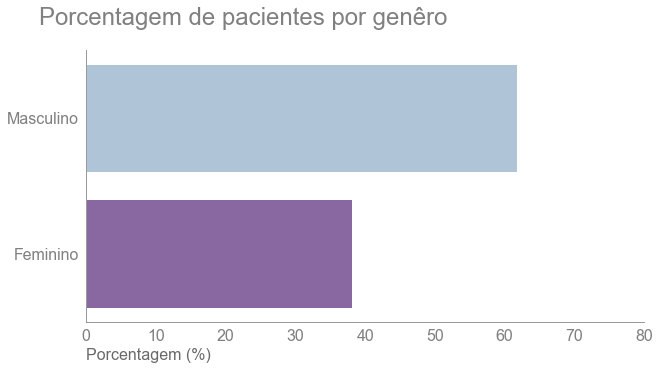

In [36]:
f = {0: 'Masculino', 1: 'Feminino'}

val = dados_tratados_por_paciente['GENDER'].value_counts(normalize=True)

for ind, vals in zip(val.index, val.values):
    print(f'{f[ind]} p = {vals*100:.2f} %')

plot_barras(titulo = 'Porcentagem de pacientes por genêro',
            x = val.values, 
            y = ['Masculino', 'Feminino'],
            xlim=(0,80),
            n_colors=2)

> Podemos observar que existe uma predominancia de pacientes do genero **masculino** de **61.82%**

## 5.2) Distribuição por percentil de idade

In [37]:
val = dados_tratados_por_paciente['AGE_PERCENTIL'].value_counts(normalize=True)
for ind, vals in zip(val.index, val.values):
    print(f'Percentil idade = {ind:.2f} p = {vals*100:.2f} %')

Percentil idade = -0.78 p = 11.97 %
Percentil idade = -0.56 p = 11.11 %
Percentil idade = -0.33 p = 10.83 %
Percentil idade = -1.00 p = 10.26 %
Percentil idade = 0.56 p = 10.26 %
Percentil idade = -0.11 p = 9.69 %
Percentil idade = 1.00 p = 9.69 %
Percentil idade = 0.33 p = 9.69 %
Percentil idade = 0.11 p = 8.55 %
Percentil idade = 0.78 p = 7.98 %


In [38]:
val = age_percentil_original.value_counts(normalize=True) 
for ind, vals in zip(val.index, val.values):
    print(f'Percentil idade = {ind:} p = {vals*100:.2f} %')

Percentil idade = 20th p = 11.97 %
Percentil idade = 30th p = 11.11 %
Percentil idade = 40th p = 10.83 %
Percentil idade = 80th p = 10.26 %
Percentil idade = 10th p = 10.26 %
Percentil idade = 50th p = 9.69 %
Percentil idade = 70th p = 9.69 %
Percentil idade = Above 90th p = 9.69 %
Percentil idade = 60th p = 8.55 %
Percentil idade = 90th p = 7.98 %


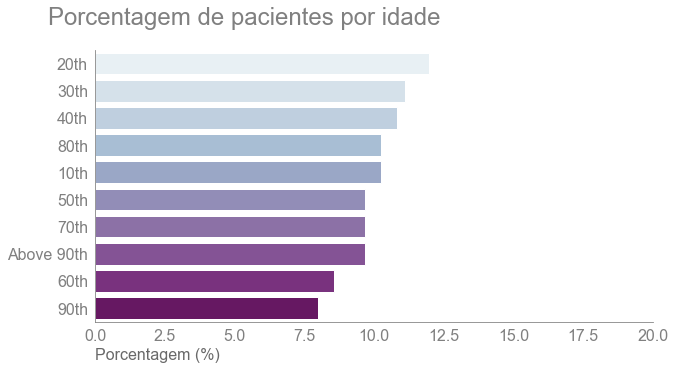

In [39]:
plot_barras(x = val.values,
            y = val.index, 
            titulo = 'Porcentagem de pacientes por idade',
            xlim=(0,20))

> O percentil das idades com mais pacientes são **20**, **30**, **40**, **80** e **10** com cerca de **10%**.

In [40]:
p_pacientes_acima_de_70 = val['70th'] + val['80th'] + val['90th'] + val['Above 90th']
p_pacientes_acima_de_60 = val['60th'] + p_pacientes_acima_de_70
print(f'Porcentagem de pacientes acima de 70 anos : {p_pacientes_acima_de_70*100:.2f} %')
print(f'Porcentagem de pacientes acima de 60 anos : {p_pacientes_acima_de_60*100:.2f} %')

Porcentagem de pacientes acima de 70 anos : 37.61 %
Porcentagem de pacientes acima de 60 anos : 46.15 %


## 5.3) Distribuição por Above_65

Abaixo de 65 p = 54.13 %
Acima de 65 p = 45.87 %


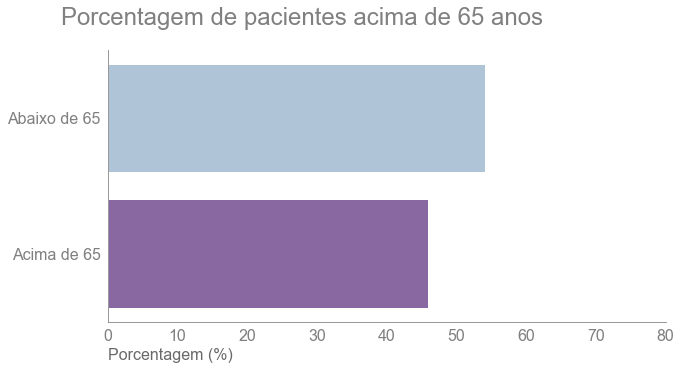

In [41]:
f = {0: 'Abaixo de 65', 1: 'Acima de 65'}

val = dados_tratados_por_paciente['AGE_ABOVE65'].value_counts(normalize=True)

for ind, vals in zip(val.index, val.values):
    print(f'{f[ind]} p = {vals*100:.2f} %')

plot_barras(titulo = 'Porcentagem de pacientes acima de 65 anos',
            x = val.values, 
            y = ['Abaixo de 65', 'Acima de 65'],
            xlim=(0,80),
            n_colors=2)

> Temos cerca de **45.87%** de pacientes acima de **65**. Considerando que **46.15%** estão acima de **60** podesse concluir que temos **0.28%** entre **60** a **64** anos.

## 5.4) Distribuição de HTN

Não p = 80.34 %
Sim p = 19.66 %


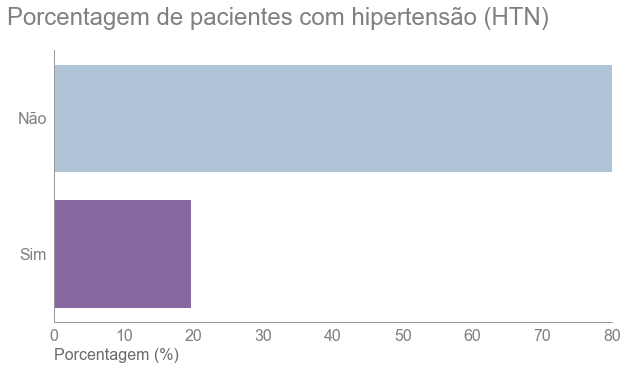

In [42]:
f = {0: 'Não', 1: 'Sim'}

val = dados_tratados_por_paciente['HTN'].value_counts(normalize=True)

for ind, vals in zip(val.index, val.values):
    print(f'{f[ind]} p = {vals*100:.2f} %')
    
plot_barras(titulo = 'Porcentagem de pacientes com hipertensão (HTN)',
            x = val.values, 
            y = ['Não', 'Sim'],
            xlim=(0,80),
            n_colors=2)

> Temos cerca de **19.66%** de pacientes com hipertensão(HTN).

## 5.5) Distribuição de paciente que foram para UTI

Não p = 53.85 %
Sim p = 46.15 %


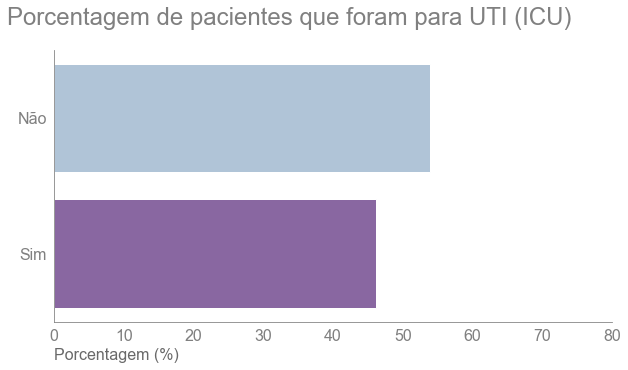

In [43]:
f = {0: 'Não', 1: 'Sim'}

val = dados_tratados_por_paciente['ICU'].value_counts(normalize=True)

for ind, vals in zip(val.index, val.values):
    print(f'{f[ind]} p = {vals*100:.2f} %')
    
plot_barras(titulo = 'Porcentagem de pacientes que foram para UTI (ICU)',
            x = val.values, 
            y = ['Não', 'Sim'],
            xlim=(0,80),
            n_colors=2)

> Temos cerca de **46.15%** de pacientes foram para **UTI**. Esse valor mostra que os dados estão bem balanciados. 

## 5.6) Distribuição de OTHER

Sim p = 81.20 %
Não p = 18.80 %


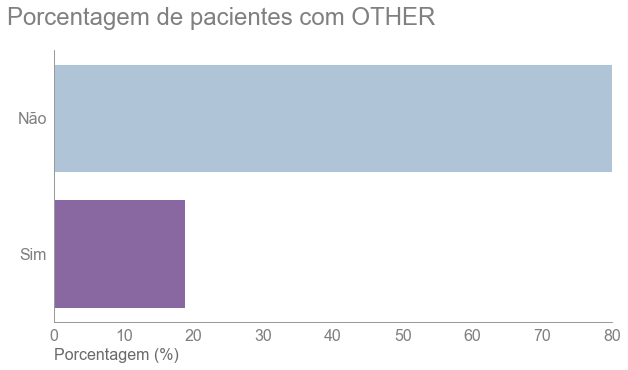

In [44]:
f = {0: 'Não', 1: 'Sim'}

val = dados_tratados_por_paciente['OTHER'].value_counts(normalize=True)

for ind, vals in zip(val.index, val.values):
    print(f'{f[ind]} p = {vals*100:.2f} %')
    
plot_barras(titulo = 'Porcentagem de pacientes com OTHER',
            x = val.values, 
            y = ['Não', 'Sim'],
            xlim=(0,80),
            n_colors=2)

## 5.6) Distribuição de DISEASE GROUPING

In [45]:
f = {0: 'Não', 1: 'Sim'}
nao = []
sim = []
for i in range(1,7):
    grupo = 'DISEASE GROUPING ' + str(i)
    val = dados_tratados_por_paciente[grupo].value_counts(normalize=True)
    nao.append(val.values[0]*100)
    sim.append(val.values[1]*100)
    print(grupo)
    for ind, vals in zip(val.index, val.values):
        print(f'{f[ind]} p = {vals:.2f} %')

DISEASE GROUPING 1
Não p = 0.89 %
Sim p = 0.11 %
DISEASE GROUPING 2
Não p = 0.98 %
Sim p = 0.02 %
DISEASE GROUPING 3
Não p = 0.91 %
Sim p = 0.09 %
DISEASE GROUPING 4
Não p = 0.98 %
Sim p = 0.02 %
DISEASE GROUPING 5
Não p = 0.87 %
Sim p = 0.13 %
DISEASE GROUPING 6
Não p = 0.95 %
Sim p = 0.05 %


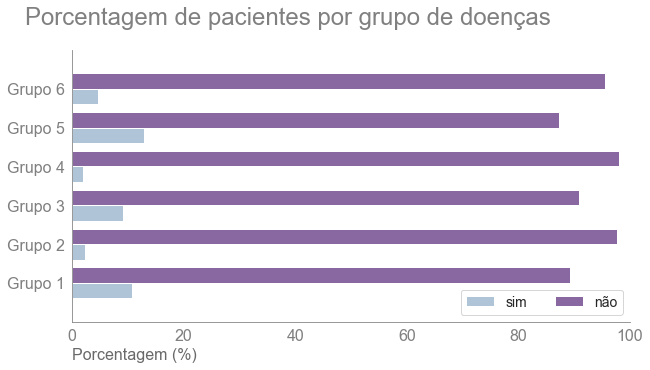

In [46]:
group = ['Grupo 1', 'Grupo 2', 'Grupo 3',
         'Grupo 4', 'Grupo 5', 'Grupo 6']

tabela_por_grupo = pd.DataFrame({'grupo': group,
                                 'não'  : nao,
                                 'sim'  : sim
                                })

dd = tabela_por_grupo.melt(id_vars=['grupo'], value_vars=['sim', 'não'])

plot_barras_grupos(dd, titulo = 'Porcentagem de pacientes por grupo de doenças')

In [47]:
tabela_por_grupo

,grupo,não,sim
0,Grupo 1,89.173789,10.826211
1,Grupo 2,97.720798,2.279202
2,Grupo 3,90.883191,9.116809
3,Grupo 4,98.005698,1.994302
4,Grupo 5,87.179487,12.820513
5,Grupo 6,95.441595,4.558405


> A maioria dos pacientes, Em média mais de **85%**, não possuem menhuma doenças dos grupos 1 a 6. 

---
# 6) Salvando os dados tratados 

In [48]:
dimensao_dados(dados_tratados_por_paciente)

Numero de linhas : 351 
Numero de colunas: 121 


In [49]:
_ = variaveis_explicativas(dados_tratados_por_paciente)

 col[  0] -> AGE_ABOVE65                         col[  1] -> AGE_PERCENTIL                       
 col[  2] -> GENDER                              col[  3] -> DISEASE GROUPING 1                  
 col[  4] -> DISEASE GROUPING 2                  col[  5] -> DISEASE GROUPING 3                  
 col[  6] -> DISEASE GROUPING 4                  col[  7] -> DISEASE GROUPING 5                  
 col[  8] -> DISEASE GROUPING 6                  col[  9] -> HTN                                 
 col[ 10] -> IMMUNOCOMPROMISED                   col[ 11] -> OTHER                               
 col[ 12] -> ALBUMIN_MEDIAN                      col[ 13] -> ALBUMIN_MEAN                        
 col[ 14] -> ALBUMIN_MIN                         col[ 15] -> ALBUMIN_MAX                         
 col[ 16] -> BE_VENOUS_MEDIAN                    col[ 17] -> BE_VENOUS_MEAN                      
 col[ 18] -> BE_VENOUS_MIN                       col[ 19] -> BE_VENOUS_MAX                       
 col[ 20] -> BLAST_M

In [53]:
path_out = '../../Dados/Tratados/'
dados_tratados_por_paciente.to_csv(path_out+'dados_tratados_por_paciente.csv', index=False)
escreve_somente_as_colunas(dados_tratados_por_paciente
                           ,path_out+'dados_tratados_por_paciente_colunas.csv')

# 7) Conclusão

> Os dados finais dem **351** linhas e **121** colunas. Como a coluna **ICU** potencialmente nos temos **120** variaves explicativas para os modelos de **ML**. Além disso a proporção de que foi para **UTI** é de **46.15 %**. O próximo [notebook](https://github.com/HenriqueCCdA/BC_DS_Projeto_Final/blob/mian/Notebooks/Selecao_variaveis/selecao_variaveis.ipynb) irá fazer uma seleção melhor da variaveis explicativas.

---
Navegação:

---

[Ir para o proximo notebook (Seleção de variaveis explicativas pela correlação)](https://github.com/HenriqueCCdA/BC_DS_Projeto_Final/blob/main/Notebooks/Selecao_variaveis/selecao_variaveis.ipynb)

---

[Retornar para README principal](https://github.com/HenriqueCCdA/BC_DS_Projeto_Final)

---